# Modelo de Classificação (Youtube Video Dataset)
https://www.kaggle.com/datasets/rahulanand0070/youtubevideodataset

In [111]:
import pandas as pd
import numpy as np
import re

# NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# SKLearn
from sklearn.model_selection import train_test_split

## Preparação do Dataset

A partir do .csv informado, vamos preparar o dataset para os algoritmos. Nesse caso, vamos remover valores nulos e filtrar as colunas de interesse.

In [112]:
df = pd.read_csv('datasets/youtube_video_dataset.csv')
df.head()

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\r\nLa...


In [113]:
colunas = list()
for coluna in df.columns:
    colunas.append(coluna)
print("Colunas:", " ".join(colunas))
print("Número de Linhas:", df.shape[0])
# Removendo as colunas que não são interessantes (nesse caso, apenas importa "Title" e "Category")
df = df.iloc[:, [0, 2, 3]]
colunas = list()
for coluna in df.columns:
    colunas.append(coluna)
print("Colunas:", " ".join(colunas))
print("Número de Linhas com Valores Nulos:", df.isna().sum().sum())
# Retirando linhas com valores nulos 
df = df.dropna()
print("Número de Linhas Após Remoção de Nulos:", df.shape[0])
print("Número de Linhas com Valores Nulos (Verificação):", df.isna().sum().sum())

Colunas: Title Videourl Category Description
Número de Linhas: 11211
Colunas: Title Category Description
Número de Linhas com Valores Nulos: 83
Número de Linhas Após Remoção de Nulos: 11128
Número de Linhas com Valores Nulos (Verificação): 0


### Novo dataset com as colunas novas e valores removidos:

In [114]:
df

,Title,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,Food,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,Food,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,Food,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\r\nLa...
...,...,...,...
11206,"art journal | shimmer sprays, stencils, collag...",Art&Music,Step by step video on creating an art journal ...
11207,Ar-Tea Collage * Mixed Media Art,Art&Music,"By: Ilene McInnes,\r\nMixed media Art and insp..."
11208,DIY Mixed Media Art Collage Greeting Cards / M...,Art&Music,Make your own Mixed Media Greeting Cards\r\n\r...
11209,Art Collage Process DecoJournal using Rice Pap...,Art&Music,Art Collage Process DecoJournal using Rice Pap...


Abaixo, foi verificado quantas categorias existem e qual a frequência de cada categoria. Como é possível observar, a mais comum é a de Viagem, enquanto a menos comum é a de História. Nesse caso, vamos mapear as classes aqui informadas para uma representação numérica.

In [115]:
df['Category'].value_counts()

travel blog           2200
Science&Technology    2074
Food                  1828
manufacturing         1699
Art&Music             1682
History               1645
Name: Category, dtype: int64

In [116]:
lista_categorias = df['Category'].value_counts().index.to_list()
dict_mapeamento = dict()
for i in range(len(lista_categorias)):
    dict_mapeamento[lista_categorias[i]] = i
df['Category'] = df['Category'].map(dict_mapeamento)
df.head()

,Title,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,2,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,2,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,2,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,2,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,2,HELP SUPPORT SINSTV!! Shop Our Sponsors!\r\nLa...


## Criação do Vetor TFIDF

O vetor TFIDF (Term Frequency - Inverse Document Frequency) é baseado no modelo de Bag of Words e procura dar mais importância para as palavras mais raras que aparecem dentro do corpo de um documento. Ainda assim, leva também em consideração as palavras mais frequentes.

In [160]:
#import nltk
#nltk.download('punkt')
#https://datascience.stackexchange.com/questions/25004/text-classifier-with-multiple-bag-of-words
import numpy as np

lista_stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

df['Title'] = df['Title'].apply(lambda x: x.lower()) # Tirando letras minúsculas
df['Title'] = df['Title'].apply(lambda x: re.sub("[^a-zA-Z]"," ", x)) # Filtrando símbolos

lista_frases = list()

for i, row in df.iterrows():
    lista_palavra = word_tokenize(row['Title'])
    lista_palavra.extend(word_tokenize(row['Description']))
    lista_string = []
    for palavra in lista_palavra:
        if palavra not in lista_stopwords:
            palavra = ps.stem(palavra) # Stemming da palavra
            lista_string.append(palavra)
    string = " ".join(lista_string)
    lista_frases.append(string)

array_frases = np.array(lista_frases)

## Separação do Dataset entre Treinamento e Teste

In [178]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(array_frases)
Y = df['Category'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.33)

## Regressão Logística

In [162]:
# https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/
import warnings 
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

kfold = StratifiedKFold(n_splits=10,  shuffle=True)

lr = LogisticRegression(solver='liblinear')
scores = cross_val_score(lr, X, Y, cv=kfold, scoring='accuracy')
print("Acurácia da Regressão Logística: %0.2f%%" % (scores.mean()*100))
print("Desvio Padrão: ", scores.std()*2*100)

Acurácia da Regressão Logística: 96.55%
Desvio Padrão:  0.935952207444578


## Gradiente Descendente Estocástico

In [163]:
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.model_selection import learning_curve

sgd = SGDClassifier(loss='perceptron', learning_rate='optimal')
scores = cross_val_score(sgd, X, Y, cv=kfold, scoring='accuracy')
print("Acurácia do SGD: %0.2f%%" % (scores.mean()*100))
print("Desvio Padrão: ", scores.std()*2*100)

perc = Perceptron()
scores = cross_val_score(perc, X, Y, cv=kfold, scoring='accuracy')
print("Acurácia do SGD (Perceptron): %0.2f%%" % (scores.mean()*100))
print("Desvio Padrão: ", scores.std()*2*100)

Acurácia do SGD: 96.15%
Desvio Padrão:  1.5476767006452066
Acurácia do SGD (Perceptron): 96.42%
Desvio Padrão:  0.760894719799209


## Regressão Logística (Avaliação)

### Curva de Aprendizado

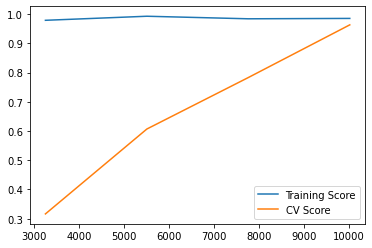

In [153]:
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

# Regressão Logística
tsize, training_score, test_score = learning_curve(lr, X, Y, cv=kfold, random_state=1000)

avg_tr_scores = np.mean(training_score, axis=1)
avg_test_scores = np.mean(test_score, axis=1)

plt.plot(tsize,avg_tr_scores,label='Training Score')
plt.plot(tsize,avg_test_scores,label='CV Score')
plt.legend()
plt.show()

### Matriz de Confusão

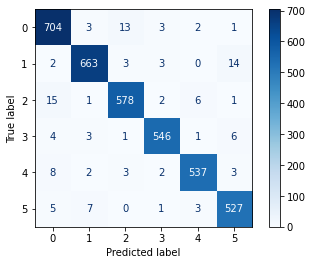

In [189]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

def matriz_confusao(modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    cm = confusion_matrix(y_test, modelo.predict(X_test))
    plot_confusion_matrix(modelo, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()

matriz_confusao(lr, X_train, X_test, y_train, y_test)

## Árvore de Decisão

In [190]:
import multiprocessing 
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
scores = cross_val_score(perc, X, Y, cv=kfold, scoring='accuracy')
print("Acurácia da Árvore de Decisão: %0.2f%%" % (scores.mean()*100))
print("Desvio Padrão: ", scores.std()*2*100)

Acurácia da Árvore de Decisão: 95.97%
Desvio Padrão:  0.6337856279832438


### Matriz de Confusão

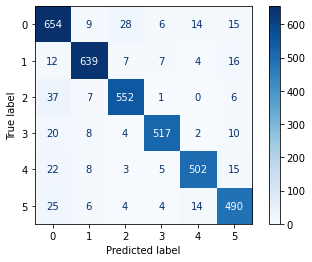

In [191]:
matriz_confusao(dt, X_train, X_test, y_train, y_test)

In [181]:
# import numpy as np
# import copy as cp
# import matplotlib.pyplot as plt

# import seaborn as sns
# from typing import Tuple
# from sklearn.metrics import confusion_matrix

# def cross_val_predict(model, kfold : StratifiedKFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:
#     model_ = cp.deepcopy(model)
#     no_classes = len(np.unique(y))
#     actual_classes = np.empty([0], dtype=int)
#     predicted_classes = np.empty([0], dtype=int)
#     predicted_proba = np.empty([0, no_classes]) 
#     for train_ndx, test_ndx in kfold.split(X):
#         train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]
#         actual_classes = np.append(actual_classes, test_y)
#         model_.fit(train_X, train_y)
#         predicted_classes = np.append(predicted_classes, model_.predict(test_X))
#         try:
#             predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
#         except:
#             predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

#     return actual_classes, predicted_classes, predicted_proba


# def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):
#     matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
#     plt.figure(figsize=(12.8,6))
#     sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
#     plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
#     plt.show()

# actual_classes, predicted_classes, _ = cross_val_predict(lr, kfold, X, Y)
# plot_confusion_matrix(actual_classes, predicted_classes, Y)